In [1]:
sc

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1584408026804_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-1>

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1  
boto                       2.49.0 
jmespath                   0.9.4  
lxml                       4.4.2  
mysqlclient                1.4.6  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.14.5 
pip                        20.0.2 
py-dateutil                2.2    
python36-sagemaker-pyspark 1.2.6  
pytz                       2019.3 
PyYAML                     3.11   
setuptools                 46.0.0 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.34.2 
windmill                   1.6

#### prepare 1 : download target raw files from publics nyc tlc website https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [2]:
import os
import urllib.request

target_2019_greencar_data_dir_path = '/tmp/nyc/tlc'

if not os.path.exists(target_2019_greencar_data_dir_path):
    os.makedirs(target_2019_greencar_data_dir_path)

for month in range(1,13):
    target_greencar_data_filepath = target_2019_greencar_data_dir_path + "/tlc.green_tripdata_2019-{0:0>2d}.csv".format(month)
    if not os.path.exists(target_greencar_data_filepath):
        urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+"green_tripdata_2019-{0:0>2d}.csv".format(month), target_greencar_data_filepath)

# check the target files
for item in os.listdir(target_2019_greencar_data_dir_path):
    item

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'tlc.green_tripdata_2019-01.csv'
'tlc.green_tripdata_2019-02.csv'
'tlc.green_tripdata_2019-03.csv'
'tlc.green_tripdata_2019-04.csv'
'tlc.green_tripdata_2019-05.csv'
'tlc.green_tripdata_2019-06.csv'
'tlc.green_tripdata_2019-07.csv'
'tlc.green_tripdata_2019-08.csv'
'tlc.green_tripdata_2019-09.csv'
'tlc.green_tripdata_2019-10.csv'
'tlc.green_tripdata_2019-11.csv'
'tlc.green_tripdata_2019-12.csv'

#### prepare 2 : download taxi_zones  lookup files from publics nyc tlc 

In [3]:
import urllib.request

target_zone_lookup_file_path = '/tmp/nyc/taxi+_zone_lookup.csv'

if not os.path.exists(target_zone_lookup_file_path):
    urllib.request.urlretrieve('https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv', target_zone_lookup_file_path)

# check the target files
for item in os.listdir('/tmp/nyc'):
    item

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'tlc'
'taxi+_zone_lookup.csv'

### prepare 3 : download  shape files from publics nyc tlc for further UI visualization

In [4]:
import zipfile

target_shapefile_path = '/tmp/nyc/taxi_zones.zip'

if not os.path.exists(target_shapefile_path):  
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", target_shapefile_path)

target_shapefile_dir = '/tmp/nyc/shape'
if not os.path.exists(target_shapefile_dir): 
    with zipfile.ZipFile(target_shapefile_path,'r') as zip_ref:
        zip_ref.extractall(target_shapefile_dir)

#check the target files
for item in os.listdir(target_shapefile_dir):
    item

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'taxi_zones.prj'
'taxi_zones.dbf'
'taxi_zones.shp'
'taxi_zones.shp.xml'
'taxi_zones.shx'
'taxi_zones.sbn'
'taxi_zones.sbx'

In [17]:
import os

os.listdir('/usr/share/aws/')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['emr', 'sagemaker-spark-sdk', 'redshift', 'aws-java-sdk', 'hmclient']

#### step 1: load raw data from s3 and do some basic clean and polishing 

In [76]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import warnings; warnings.simplefilter('ignore')
import datetime

# config spark to build context
spark=SparkSession.builder.appName("NYC.TLC-Green-Car-Data-ETL").getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "America/New_York")

# read in our raw dataset
# add new column :pickup_hour
# add new column :dropoff_hour
# add new column :duration
# add new column :minute_rate
# add new column :average_speed

# remove colum :store_and_fwd_flag
# remove colum :ehail_fee
# remove colum :congestion_surcharge

df = spark.read.option('header', 'true') \
    .option('mode', 'FAILFAST') \
    .option('timeStampFormat', 'yyyy-MM-dd HH:mm:ss') \
    .option('columnNameOfCorruptRecord', 'error') \
    .csv('s3://data-etl-o-original-raw/green/*.csv') \
    .filter(f.year('lpep_pickup_datetime') == 2019) \
    .withColumn('trip_distance',f.col('trip_distance').cast(DoubleType())) \
    .withColumn('pickup_hour',f.hour('lpep_pickup_datetime')) \
    .withColumn('dropoff_hour',f.hour('lpep_dropoff_datetime')) \
    .withColumn('duration', f.unix_timestamp('lpep_dropoff_datetime') - f.unix_timestamp('lpep_pickup_datetime')) \
    .withColumn('minute_rate',f.when(f.col('total_amount') <= 0.001,0).otherwise(f.col('total_amount')/f.col('duration') * 60)) \
    .withColumn('average_speed',f.when(f.col('trip_distance') < 0.001,0).otherwise(f.col('trip_distance')/f.col('duration') * 60 * 60)) \
    .drop('store_and_fwd_flag') \
    .drop('ehail_fee') \
    .drop('congestion_surcharge')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- VendorID: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- duration: long (nullable = true)
 |-- minute_rate: double (nullable = true)
 |-- average_speed: double (nullable = true)

In [3]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("pyshp")
sc.install_pypi_package("shapely")
sc.install_pypi_package("descartes")
sc.install_pypi_package("sqlalchemy")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.2-cp36-cp36m-manylinux1_x86_64.whl (10.1 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

Processing /mnt/var/lib/livy/.cache/pip/wheels/1b/ab/b5/333342ac6838b5ab6977d3b5d29140cf3e60b01b220f8178c0/pyshp-2.1.0-py3-none-any.whl

  Using cached Shapely-1.7.0-cp36-cp36m-manylinux1_x86_64.whl (1.8 MB)

  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached matplotlib-3.2.0-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (90 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

Processing /mnt/var/lib/livy/.cache/pip/wheels/4a/1b/3a/c73044d7be48baeb47cbee343334f7803726ca1e9ba7b29095/SQLAlchemy-1.3.15-cp36-cp36m-linux_x86_64.whl

In [4]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:////tmp/nyc/nyc_tlc_green-car_database.db')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# load a local copy from internet data
j, chunksize = 1, 100000
for month in range(1,13):
    fp = "/tmp/nyc/tlc/tlc.green_tripdata_2019-{0:0>2d}.csv".format(month)
    for ldf in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        ldf.index += j
        ldf.to_sql('local_table', nyc_database, if_exists='append')
        j = ldf.index[-1] + 1
del ldf


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### step 2: cache data im memory for comparing some key properties

In [5]:
dfcache = df.cache()

# dfcache
## check schema structure
df.printSchema(),dfcache.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- VendorID: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- duration: long (nullable = true)
 |-- minute_rate: double (nullable = true)
 |-- average_speed: double (nullable = true)

root
 |-- VendorID: strin

### step 3: processing further polishing and transformation

In [93]:
## fix colums with regular names

for c in df.columns:
    df = df.withColumnRenamed(c, c.replace(' ', '_'))

## polish data

## remove data which is tooooo small and ilegal value
df = df.filter(df['trip_distance'] >= 0.001)

## round minute_rate and average_speed to scale 3 

df = df.withColumn('minute_rate', f.round(df['minute_rate'],4))

df = df.withColumn('average_speed', f.round(df['average_speed'],4))

df = df.withColumn('average_speed', f.round(df['trip_distance'],4))

# rename 'VendorID'
# df = df.withColumnRenamed('VendorID', 'vendor_id')

# rename passenger_count to pcount shortly
df = df.withColumnRenamed('passenger_count', 'p_count')

# df.show(10)

df.select(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration','total_amount','trip_distance','minute_rate','average_speed']) \
.show(10)

## Write Data Back to S3 using AWS API
# currenttime = datetime.datetime.now()

# df.write.option('compression', 'snappy') \
#    .save( "s3://data-etl-o-target-0/result/green/green_car_data_processed_{date}/".format(date=currenttime.strftime('%Y%m%d%H%M%s')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|duration|total_amount|trip_distance|minute_rate|average_speed|
+--------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|       2| 2019-01-01 00:10:16|  2019-01-01 00:16:32|     376|         7.3|         0.86|     1.1649|         0.86|
|       2| 2019-01-01 00:27:11|  2019-01-01 00:31:38|     267|         5.8|         0.66|     1.3034|         0.66|
|       2| 2019-01-01 00:46:20|  2019-01-01 01:04:54|    1114|       19.71|         2.68|     1.0616|         2.68|
|       2| 2019-01-01 00:19:06|  2019-01-01 00:39:43|    1237|        19.3|         4.53|     0.9361|         4.53|
|       2| 2019-01-01 00:12:35|  2019-01-01 00:19:09|     394|         7.8|         1.05|     1.1878|         1.05|
|       2| 2019-01-01 00:47:55|  2019-01-01 01:00:01|     726|        14

In [7]:
## caculate and comparing the count of the target data 

df.columns,dfcache.columns

df.count(), dfcache.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(5779303, 5929810)

#### step 4: load taxi zone data from s3 for future merging using

In [8]:
#read in our raw dataset
dfz = spark.read.option('header', 'true') \
    .option('mode', 'FAILFAST') \
    .option('columnNameOfCorruptRecord', 'error') \
    .csv('s3://data-etl-o-original-raw/zone/nyc.tlc.taxi_zone_lookup.csv')

dfzcache = dfz.cache()

# dfz.count(),dfz.columns

dfz.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [49]:
lddf = pd.read_csv('/tmp/nyc/taxi+_zone_lookup.csv',index_col='LocationID').replace(np.NaN, '')
lddf.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  Borough                     Zone service_zone
LocationID                                                     
1                     EWR           Newark Airport          EWR
2                  Queens              Jamaica Bay    Boro Zone
3                   Bronx  Allerton/Pelham Gardens    Boro Zone
4               Manhattan            Alphabet City  Yellow Zone
5           Staten Island            Arden Heights    Boro Zone

In [56]:
ldfz = spark.createDataFrame(lddf)
# ldfz.select('Borough').distinct().show()
ldfz.select('Borough').groupBy('Borough').agg({'Borough': 'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------+
|      Borough|count(Borough)|
+-------------+--------------+
|       Queens|            69|
|          EWR|             1|
|      Unknown|             2|
|     Brooklyn|            61|
|Staten Island|            20|
|    Manhattan|            69|
|        Bronx|            43|
+-------------+--------------+

In [9]:
tmp = df.select(['VendorID','PULocationID', 'DOLocationID', 'p_count', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration','total_amount','trip_distance','minute_rate','average_speed'])
tmp.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------------+------------+-------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|VendorID|PULocationID|DOLocationID|p_count|lpep_pickup_datetime|lpep_dropoff_datetime|duration|total_amount|trip_distance|minute_rate|average_speed|
+--------+------------+------------+-------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|       2|          97|          49|      2| 2019-01-01 00:10:16|  2019-01-01 00:16:32|     376|         7.3|          .86|     1.1649|        8.234|
|       2|          49|         189|      2| 2019-01-01 00:27:11|  2019-01-01 00:31:38|     267|         5.8|          .66|     1.3034|       8.8989|
|       2|         189|          17|      2| 2019-01-01 00:46:20|  2019-01-01 01:04:54|    1114|       19.71|         2.68|     1.0616|       8.6607|
|       2|          82|         258|      1| 2019-01-01 00:19:06|  2019-01-01 00:39:43|    1237|    

In [10]:
df.groupBy('p_count').count().orderBy('count', ascending=False).limit(10).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+
|p_count|  count|
+-------+-------+
|      1|4705631|
|      2| 406405|
|   null| 304825|
|      5| 161783|
|      6|  86660|
|      3|  75135|
|      4|  28172|
|      0|  10584|
|      8|     58|
|      7|     36|
+-------+-------+

In [52]:
toplo = df.groupBy('PULocationID').count().orderBy('count', ascending=False).limit(10)
toplo.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|PULocationID| count|
+------------+------+
|          74|457848|
|          75|368752|
|          41|333623|
|          82|259303|
|           7|244131|
+------------+------+
only showing top 5 rows

In [15]:
toplo2 = df.groupBy('PULocationID','DOLocationID').count().orderBy('count', ascending=False).limit(10)
toplo2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------+-----+
|PULocationID|DOLocationID|count|
+------------+------------+-----+
|          75|          74|72275|
|           7|           7|67275|
|          74|          75|61992|
|          41|          42|56941|
|          95|          95|52950|
+------------+------------+-----+
only showing top 5 rows

In [58]:
dfz.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows

In [59]:
top_5_loc_names = toplo2.join(dfz, toplo2['PULocationID'].eqNullSafe(dfz['LocationID']),'left') \
            .withColumnRenamed('Borough','FromLocation') \
            .drop('LocationID') \
            .orderBy('count', ascending=False)
top_5_loc_names.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------+-----+------------+-----------------+------------+
|PULocationID|DOLocationID|count|FromLocation|             Zone|service_zone|
+------------+------------+-----+------------+-----------------+------------+
|          75|          74|72275|   Manhattan|East Harlem South|   Boro Zone|
|           7|           7|67275|      Queens|          Astoria|   Boro Zone|
|          74|          75|61992|   Manhattan|East Harlem North|   Boro Zone|
|          41|          42|56941|   Manhattan|   Central Harlem|   Boro Zone|
|          95|          95|52950|      Queens|     Forest Hills|   Boro Zone|
|          82|         129|49679|      Queens|         Elmhurst|   Boro Zone|
|          41|          41|43924|   Manhattan|   Central Harlem|   Boro Zone|
|          74|          41|43754|   Manhattan|East Harlem North|   Boro Zone|
|          74|          74|43477|   Manhattan|East Harlem North|   Boro Zone|
|         129|         129|43268|      Queens|  Jackson Heights|

In [114]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
display,%%display -n 100my_spark_df,"Displays Spark dataframe as a beautiful HTML table with horizontal and vertical scroll bars(if necessary). Parameters: -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe to display. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


In [23]:
top_5_loc_names.createOrReplaceTempView("top_5_loc_names_views")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
%%sql -o top_5_loc_names -n -1
select 'PULocationID','DOLocationID','count' from top_5_loc_names_views
group by 'PULocationID','DOLocationID'
ORDER BY count Desc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [17]:
import os
all_files_in_cur_dir = os.listdir('.') 
csvfileslist = list(filter(lambda x:(x[-6:] == '.ipynb'),all_files_in_cur_dir))
csvfileslist

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

In [18]:
csvfileslist = list(os.listdir('.'))
csvfileslist
os.listdir('.')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['var', 'lib64', 'emr', 'home', 'lost+found', 'sbin', 'selinux', 'lib', 'srv', 'device-names.json', 'media', 'tmp', 'mnt', 'run', 'cgroup', 'bin', 'etc', 'dev', 'mnt1', '.autofsck', 'boot', 'opt', 'usr', 'proc', 'sys', 'root', 'local', '.autorelabel']

In [16]:
tmpfile = list(filter(lambda x:(x[-4:] == '.zip'),os.listdir('/tmp')))
tmpfile

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

#### step 5: handle taxi_zones shape files for further UI visualization

In [60]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# define processing to extract LocationID、longitude、latitude

In [11]:
def get_lat_lon(sf,shp_dic):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"]).replace(np.NaN, '')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
## read previous file we download and extracted to /tmp/nyc/shape/
sf = shapefile.Reader("/tmp/nyc/shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf,shp_dic).set_index("LocationID"), on="LocationID")

## df_loc.head()
## ported to spark to analyze
spark_dfl = spark.createDataFrame(df_loc)
spark_dfl.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|OBJECTID|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|
+--------+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|       1| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 936681.7498053049|190522.13027768553|
|       2|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1033536.0827942044|161853.98229982704|
|       3|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|  1027136.41219455|254730.01084850729|
|       4|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990424.0195702165|203100.04043184966|
|       5|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island| 932133.2098496

### define processing for draw region map and draw zone map by plot

In [13]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

# Draw Borough region

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

# get boundaries of zone
# %matplotlib inline

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

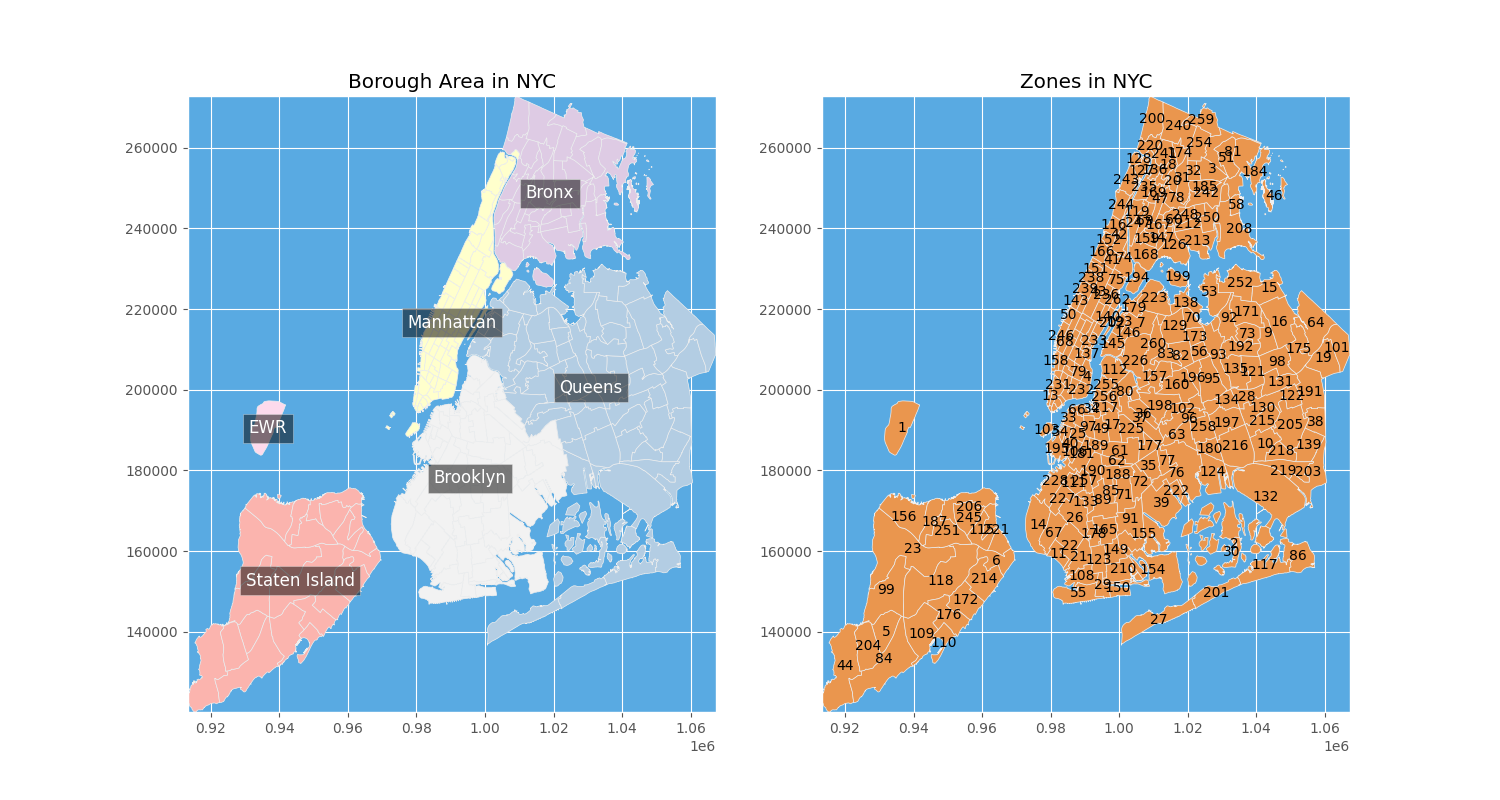

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Borough Area in NYC")
draw_region_map(ax, sf)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

%matplot plt

In [15]:

df.select(['VendorID','PULocationID', 'DOLocationID', 'p_count', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration','total_amount','trip_distance','minute_rate','average_speed']) \
.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------------+------------+-------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|VendorID|PULocationID|DOLocationID|p_count|lpep_pickup_datetime|lpep_dropoff_datetime|duration|total_amount|trip_distance|minute_rate|average_speed|
+--------+------------+------------+-------+--------------------+---------------------+--------+------------+-------------+-----------+-------------+
|       2|          97|          49|      2| 2019-01-01 00:10:16|  2019-01-01 00:16:32|     376|         7.3|          .86|     1.1649|        8.234|
|       2|          49|         189|      2| 2019-01-01 00:27:11|  2019-01-01 00:31:38|     267|         5.8|          .66|     1.3034|       8.8989|
|       2|         189|          17|      2| 2019-01-01 00:46:20|  2019-01-01 01:04:54|    1114|       19.71|         2.68|     1.0616|       8.6607|
|       2|          82|         258|      1| 2019-01-01 00:19:06|  2019-01-01 00:39:43|    1237|    

In [45]:
spark_dfl.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|OBJECTID|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|
+--------+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|       1| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 936681.7498053049|190522.13027768553|
|       2|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1033536.0827942044|161853.98229982704|
|       3|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|  1027136.41219455|254730.01084850729|
|       4|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990424.0195702165|203100.04043184966|
|       5|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island| 932133.2098496

In [43]:
dfz.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 10 rows

In [22]:
dfz.columns,df.columns,spark_dfl.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(['LocationID', 'Borough', 'Zone', 'service_zone'], ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'RatecodeID', 'PULocationID', 'DOLocationID', 'p_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'pickup_hour', 'dropoff_hour', 'duration', 'minute_rate', 'average_speed'], ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'longitude', 'latitude'])

### for business trending ,we need to exploring some data from merged data

### Q1: Which zone have most pickups and drop-offs?

In [16]:
## count().orderBy('count', ascending=False).limit(10)

df_pu = df.select(f.col("PULocationID").alias("LocationID")).groupby('LocationID').count().withColumnRenamed('count', 'pu_count')
df_do = df.select(f.col("DOLocationID").alias("LocationID")).groupby('LocationID').count().withColumnRenamed('count', 'do_count')

## use taxi zone talbe
joined1 = df_pu.join(df_do, 'LocationID', 'left').withColumn('total_count', df_pu.pu_count + df_do.do_count)

joined1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+--------+-----------+
|LocationID|pu_count|do_count|total_count|
+----------+--------+--------+-----------+
|       125|      77|    3586|       3663|
|       124|    2441|    3898|       6339|
|        51|   15028|   14029|      29057|
|         7|  244131|  150145|     394276|
|       169|   10191|   14368|      24559|
+----------+--------+--------+-----------+
only showing top 5 rows

In [67]:
dfz.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows

In [17]:
# order tables
joined2 = joined1.join(dfz,'LocationID', 'left') \
    .withColumn("LocationID", f.col('LocationID').cast(IntegerType())) \
    .orderBy('LocationID')

joined2.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+--------+-----------+-------------+--------------------+------------+
|LocationID|pu_count|do_count|total_count|      Borough|                Zone|service_zone|
+----------+--------+--------+-----------+-------------+--------------------+------------+
|         1|      22|    1822|       1844|          EWR|      Newark Airport|         EWR|
|         2|       9|      64|         73|       Queens|         Jamaica Bay|   Boro Zone|
|         3|    5097|    5745|      10842|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|     183|    5936|       6119|    Manhattan|       Alphabet City| Yellow Zone|
|         5|      60|     125|        185|Staten Island|       Arden Heights|   Boro Zone|
|         6|      57|     150|        207|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|  244131|  150145|     394276|       Queens|             Astoria|   Boro Zone|
|         8|      86|     779|        865|       Queens|        Astoria Park|   Boro Zone|

In [18]:
# joined2.select('*').limit(10).show(10)
# joinedtemplate = joined2.createOrReplaceTempView("joinedtemplate")
#df_putp5 = joined2.orderBy('pu_count', ascending=False).select('*').limit(5)

df_putp5 = joined2.orderBy('pu_count', ascending=False).limit(5)
df_putp5.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+--------+-----------+---------+-----------------+------------+
|LocationID|pu_count|do_count|total_count|  Borough|             Zone|service_zone|
+----------+--------+--------+-----------+---------+-----------------+------------+
|        74|  457848|  222492|     680340|Manhattan|East Harlem North|   Boro Zone|
|        75|  368752|  159362|     528114|Manhattan|East Harlem South|   Boro Zone|
|        41|  333623|  184460|     518083|Manhattan|   Central Harlem|   Boro Zone|
|        82|  259303|   98800|     358103|   Queens|         Elmhurst|   Boro Zone|
|         7|  244131|  150145|     394276|   Queens|          Astoria|   Boro Zone|
+----------+--------+--------+-----------+---------+-----------------+------------+

In [19]:

#df_dotp5 = joined2.orderBy('do_count', ascending=False).select(['LocationID','do_count','pu_count','Borough','Zone'])

df_dotp5 = joined2.orderBy('do_count', ascending=False).limit(5)

df_dotp5.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+--------+-----------+---------+--------------------+------------+
|LocationID|pu_count|do_count|total_count|  Borough|                Zone|service_zone|
+----------+--------+--------+-----------+---------+--------------------+------------+
|        74|  457848|  222492|     680340|Manhattan|   East Harlem North|   Boro Zone|
|        42|  200203|  206448|     406651|Manhattan|Central Harlem North|   Boro Zone|
|        41|  333623|  184460|     518083|Manhattan|      Central Harlem|   Boro Zone|
|        75|  368752|  159362|     528114|Manhattan|   East Harlem South|   Boro Zone|
|       129|  151117|  151820|     302937|   Queens|     Jackson Heights|   Boro Zone|
+----------+--------+--------+-----------+---------+--------------------+------------+

In [20]:
# get UI parameters

# [Row(LocationID=74, pu_count=457848), Row(LocationID=75, pu_count=368752), Row(LocationID=41, pu_count=333623)]
#list_borough =  [row.LocationID for row in joined2.select(['LocationID','pu_count']).collect()]

list_borough = joined2.select("borough").rdd.flatMap(lambda x: x).collect()
list_pu_count = joined2.select("pu_count").rdd.flatMap(lambda x: x).collect()
list_do_count = joined2.select("do_count").rdd.flatMap(lambda x: x).collect()

#list_LocationID[1],list_pu_count[1]
# get the pick mount from different zone 

pu_mount_list = dict(zip(list_borough, list_pu_count))
list_index_df_putp5 = df_putp5.select("LocationID").rdd.flatMap(lambda x: x).collect()

do_mount_list = dict(zip(list_borough, list_do_count))
list_index_df_dotp5 = df_dotp5.select("LocationID").rdd.flatMap(lambda x: x).collect()

pu_mount_list,do_mount_list,list_index_df_putp5,list_index_df_dotp5

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

({'EWR': 22, 'Queens': 122603, 'Bronx': 5385, 'Manhattan': 3969, 'Staten Island': 104, 'Brooklyn': 4341, 'Unknown': 2231}, {'EWR': 1822, 'Queens': 66735, 'Bronx': 5988, 'Manhattan': 59614, 'Staten Island': 242, 'Brooklyn': 12840, 'Unknown': 12852}, [74, 75, 41, 82, 7], [74, 42, 41, 75, 129])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

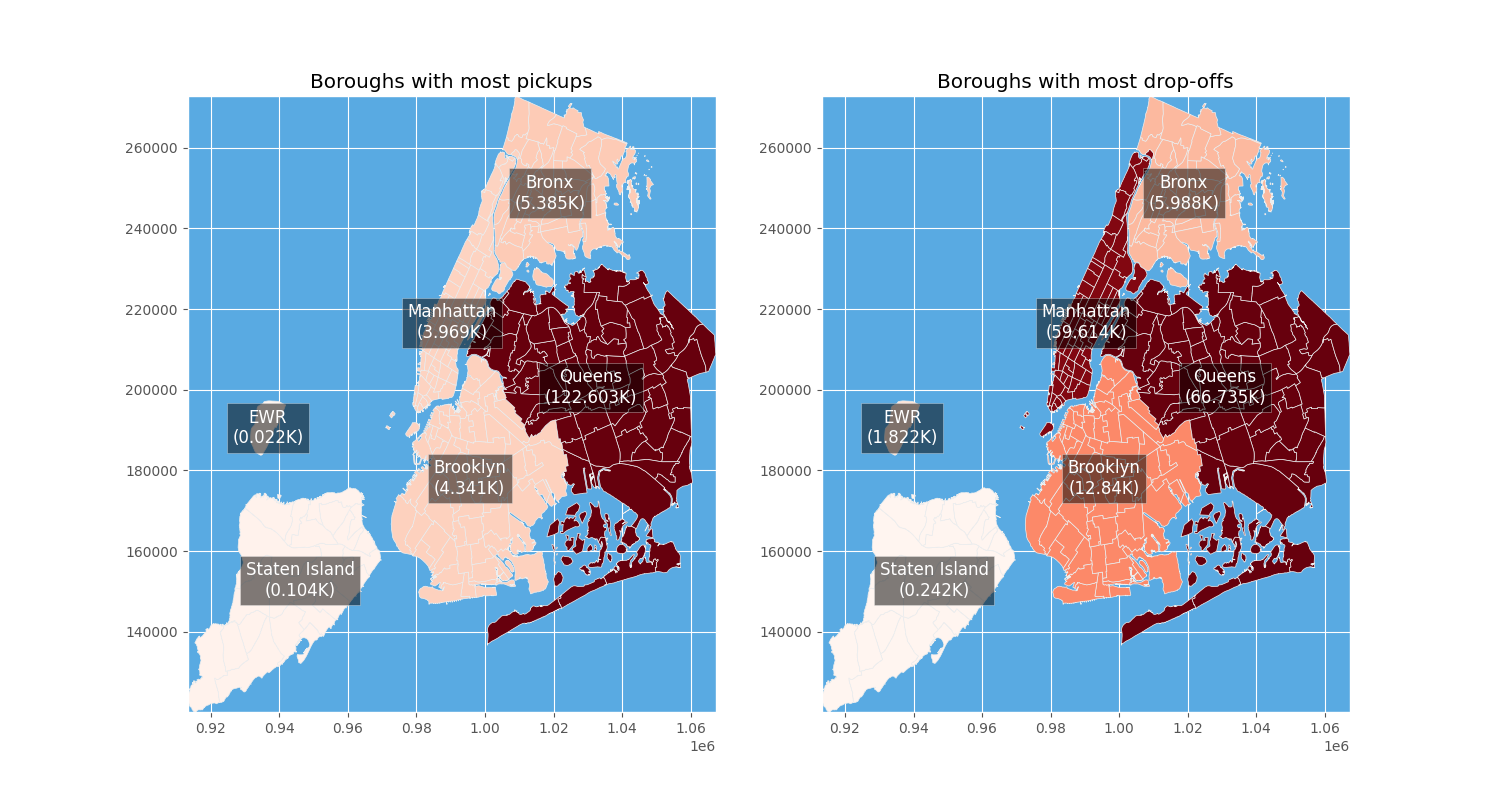

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = pu_mount_list)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = do_mount_list)

%matplot plt

In [22]:
#df_do = df.select(f.col("DOLocationID").alias("LocationID")).groupby('LocationID').count().withColumnRenamed('count', 'do_count')

df_pu_busy_hour = df.select(f.col('pickup_hour').alias('time')).groupby('time').count().withColumnRenamed('count','pu_count')
df_do_busy_hour = df.select(f.col('dropoff_hour').alias('time')).groupby('time').count().withColumnRenamed('count','do_count')

df_busy_hours = df_pu_busy_hour.join(df_do_busy_hour, on='time').orderBy('time')

df_busy_hours.show(24)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+--------+
|time|pu_count|do_count|
+----+--------+--------+
|   0|  147628|  164963|
|   1|  104031|  111733|
|   2|   71410|   75744|
|   3|   57233|   57435|
|   4|   53122|   54136|
|   5|   49177|   44899|
|   6|   94076|   72274|
|   7|  187133|  155687|
|   8|  280271|  258021|
|   9|  308658|  313954|
|  10|  303486|  308819|
|  11|  299780|  297715|
|  12|  301585|  302508|
|  13|  296985|  296356|
|  14|  323943|  311535|
|  15|  355637|  343031|
|  16|  378362|  369489|
|  17|  397231|  395975|
|  18|  406154|  424678|
|  19|  360950|  383900|
|  20|  299163|  311343|
|  21|  268878|  274447|
|  22|  234410|  241824|
|  23|  200000|  208837|
+----+--------+--------+

In [31]:
list_hours_time = df_busy_hours.select('time').rdd.flatMap(lambda x: x).collect()
list_pu_hours_datas = df_busy_hours.select('pu_count').rdd.flatMap(lambda x: x).collect()
list_do_hours_datas = df_busy_hours.select('do_count').rdd.flatMap(lambda x: x).collect()

list_hours_time,list_pu_hours_datas,list_do_hours_datas

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [147628, 104031, 71410, 57233, 53122, 49177, 94076, 187133, 280271, 308658, 303486, 299780, 301585, 296985, 323943, 355637, 378362, 397231, 406154, 360950, 299163, 268878, 234410, 200000], [164963, 111733, 75744, 57435, 54136, 44899, 72274, 155687, 258021, 313954, 308819, 297715, 302508, 296356, 311535, 343031, 369489, 395975, 424678, 383900, 311343, 274447, 241824, 208837])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

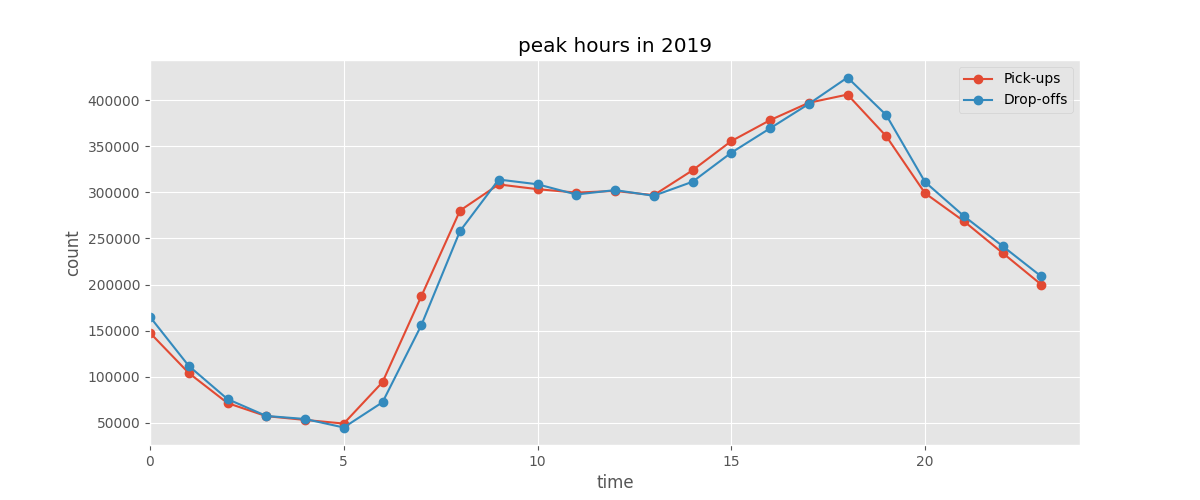

In [61]:
#ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,1))

fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('peak hours in 2019')

ax.plot(list_hours_time, list_pu_hours_datas, '-o', label='Pick-ups')

ax.plot(list_hours_time, list_do_hours_datas, '-o', label='Drop-offs')

ax.set_xlabel('time')
ax.set_ylabel('count')


ax.legend()

plt.show()

%matplot plt

### Q3: What are the differences between short and long distance trips of taking taxi?

In [77]:
# avoid distance less than 0

#df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record WHERE trip_distance > 0', nyc_database)
#df_dist['trip_distance'].describe()

# get all distance

df_trip_distance = df.where(f.col('trip_distance') > 0.0001).select('trip_distance')

df_trip_distance.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|trip_distance|
+-------------+
|         0.86|
|         0.66|
|         2.68|
|         4.53|
|         1.05|
|         3.77|
|          4.1|
|         7.75|
|         3.68|
|         6.84|
+-------------+
only showing top 10 rows

In [78]:
df_trip_distance.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- trip_distance: double (nullable = true)

In [102]:
#from decimal import Decimal
# lambda x: round(Decimal(x),3)

list_trip_distance = df_trip_distance.select('trip_distance').rdd.flatMap(lambda x: x).collect()

for i in range(10) :
    list_trip_distance[i]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8600000143051147
0.6600000262260437
2.680000066757202
4.53000020980835
1.0499999523162842
3.7699999809265137
4.099999904632568
7.75
3.680000066757202
6.840000152587891

In [104]:
df_trip_distance.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- trip_distance: float (nullable = true)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

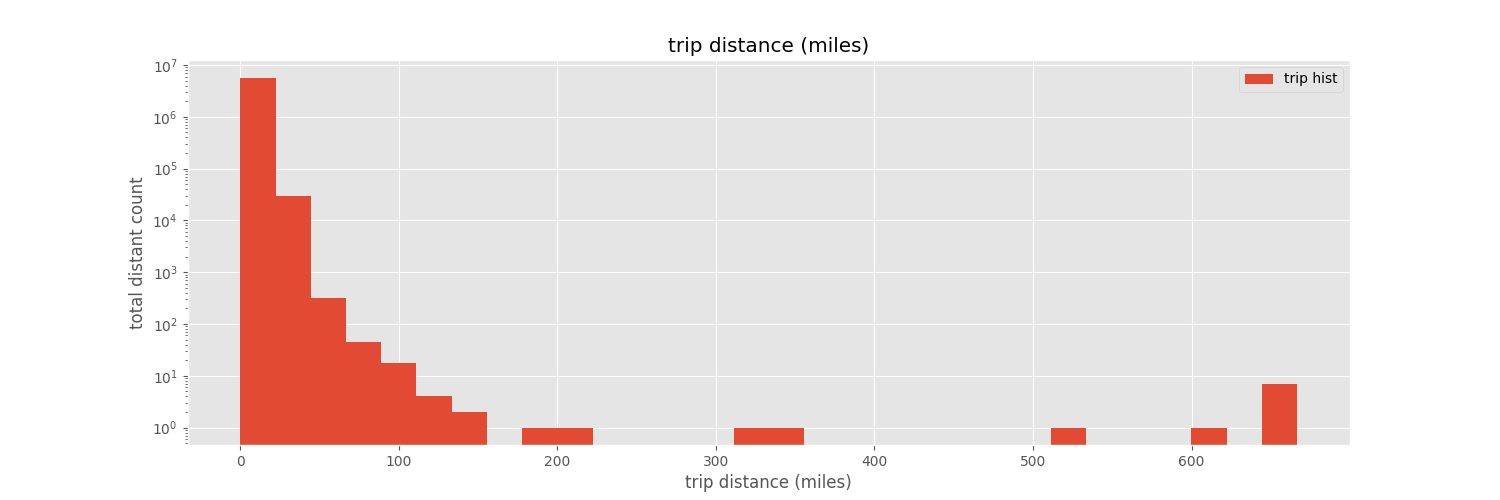

In [106]:

fig, ax = plt.subplots(figsize=(15,5))

ax.set_title('trip distance (miles)')

ax.set_yscale('log')
ax.set_xlabel('trip distance (miles)')
ax.set_ylabel('total distant count')
ax.hist(list_trip_distance,bins=30,label='trip hist')

ax.legend()
plt.show()

%matplot plt

In [115]:
df_q3_short_count = df.where(f.col('trip_distance') < 30 ).where(f.col('trip_distance') > 0).select('trip_distance').count()

df_q3_long_count = df.where(f.col('trip_distance') >= 30 ).select('trip_distance').count()

df_q3_short_count,df_q3_long_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(5775086, 4217)

In [118]:
df_short_count = df.where(f.col('trip_distance') < 30 ).where(f.col('trip_distance') > 0).select(['pickup_hour','dropoff_hour']).groupBy(['pickup_hour','dropoff_hour']).count()
df_long_count = df.where(f.col('trip_distance') > 30 ).select(['pickup_hour','dropoff_hour']).groupBy(['pickup_hour','dropoff_hour']).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [119]:
df_short_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------+------+
|pickup_hour|dropoff_hour| count|
+-----------+------------+------+
|         15|          14|   661|
|          3|          22|     1|
|         23|           6|     3|
|          3|          15|     1|
|         13|          10|    12|
|          9|          10| 81716|
|          1|           0|   353|
|          9|          16|     1|
|         15|          15|252552|
|          3|           1|    31|
|          7|           4|     1|
|          2|           2| 59807|
|         18|          16|    60|
|         22|           9|     1|
|         12|          19|     2|
|         22|           6|     3|
|         18|           1|     2|
|          8|           9| 86484|
|         20|          22|   182|
|         19|           2|     1|
+-----------+------------+------+
only showing top 20 rows

In [120]:
df_long_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------+-----+
|pickup_hour|dropoff_hour|count|
+-----------+------------+-----+
|         15|          14|    1|
|          9|          10|  169|
|          9|          16|    3|
|          4|          10|    1|
|          1|           0|    1|
|         15|          15|    6|
|          2|           2|    7|
|         12|          19|    4|
|         18|          16|    1|
|          8|           9|  113|
|         20|          22|   25|
|         10|          15|    1|
|         22|          23|  187|
|          7|          14|    2|
|         12|          17|    6|
|          2|           3|   28|
|          4|           7|    1|
|         14|          16|   51|
|         14|          14|    5|
|          1|           2|   47|
+-----------+------------+-----+
only showing top 20 rows

In [121]:
# render clock time

def plt_clock(ax, radii, title, color):
    
    N = 24
    bottom = 2
    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # width of each bin on the plot
    width = (2*np.pi) / N   
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)
    
# diff time

def diff_short_long_trip_on_time():
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#df_short_count = df_short_count.
df_trip_hours_theta = df_long_count.join(df_short_count,['pickup_hour','dropoff_hour'],'rightouter')
df_trip_hours_theta.show(10)